In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/career-con-2019/sample_submission.csv
/kaggle/input/career-con-2019/X_test.csv
/kaggle/input/career-con-2019/y_train.csv
/kaggle/input/career-con-2019/X_train.csv


# Will need to merge input & output csv files

# Import pytorch , pytorch lightning etc... 

# All bulk imports below

In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint , EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

# below import is already deprecated so use torch metrics
# from pytorch_lightning.metrics.functional import accuracy
from torchmetrics import Accuracy
from sklearn.metrics import classification_report , confusion_matrix



# Set up matplotlib

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ['#01BEFE', '#FFDD00','#FF7D00','#FF006D','#ADFF02', '#8F00FF']

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize']=16,10

In [4]:
pl.seed_everything(42) # make everything reproducible

42

In [5]:
X_train = pd.read_csv('/kaggle/input/career-con-2019/X_train.csv')
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [6]:
y_train = pd.read_csv('/kaggle/input/career-con-2019/y_train.csv')
y_train.head() # features that are labels

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


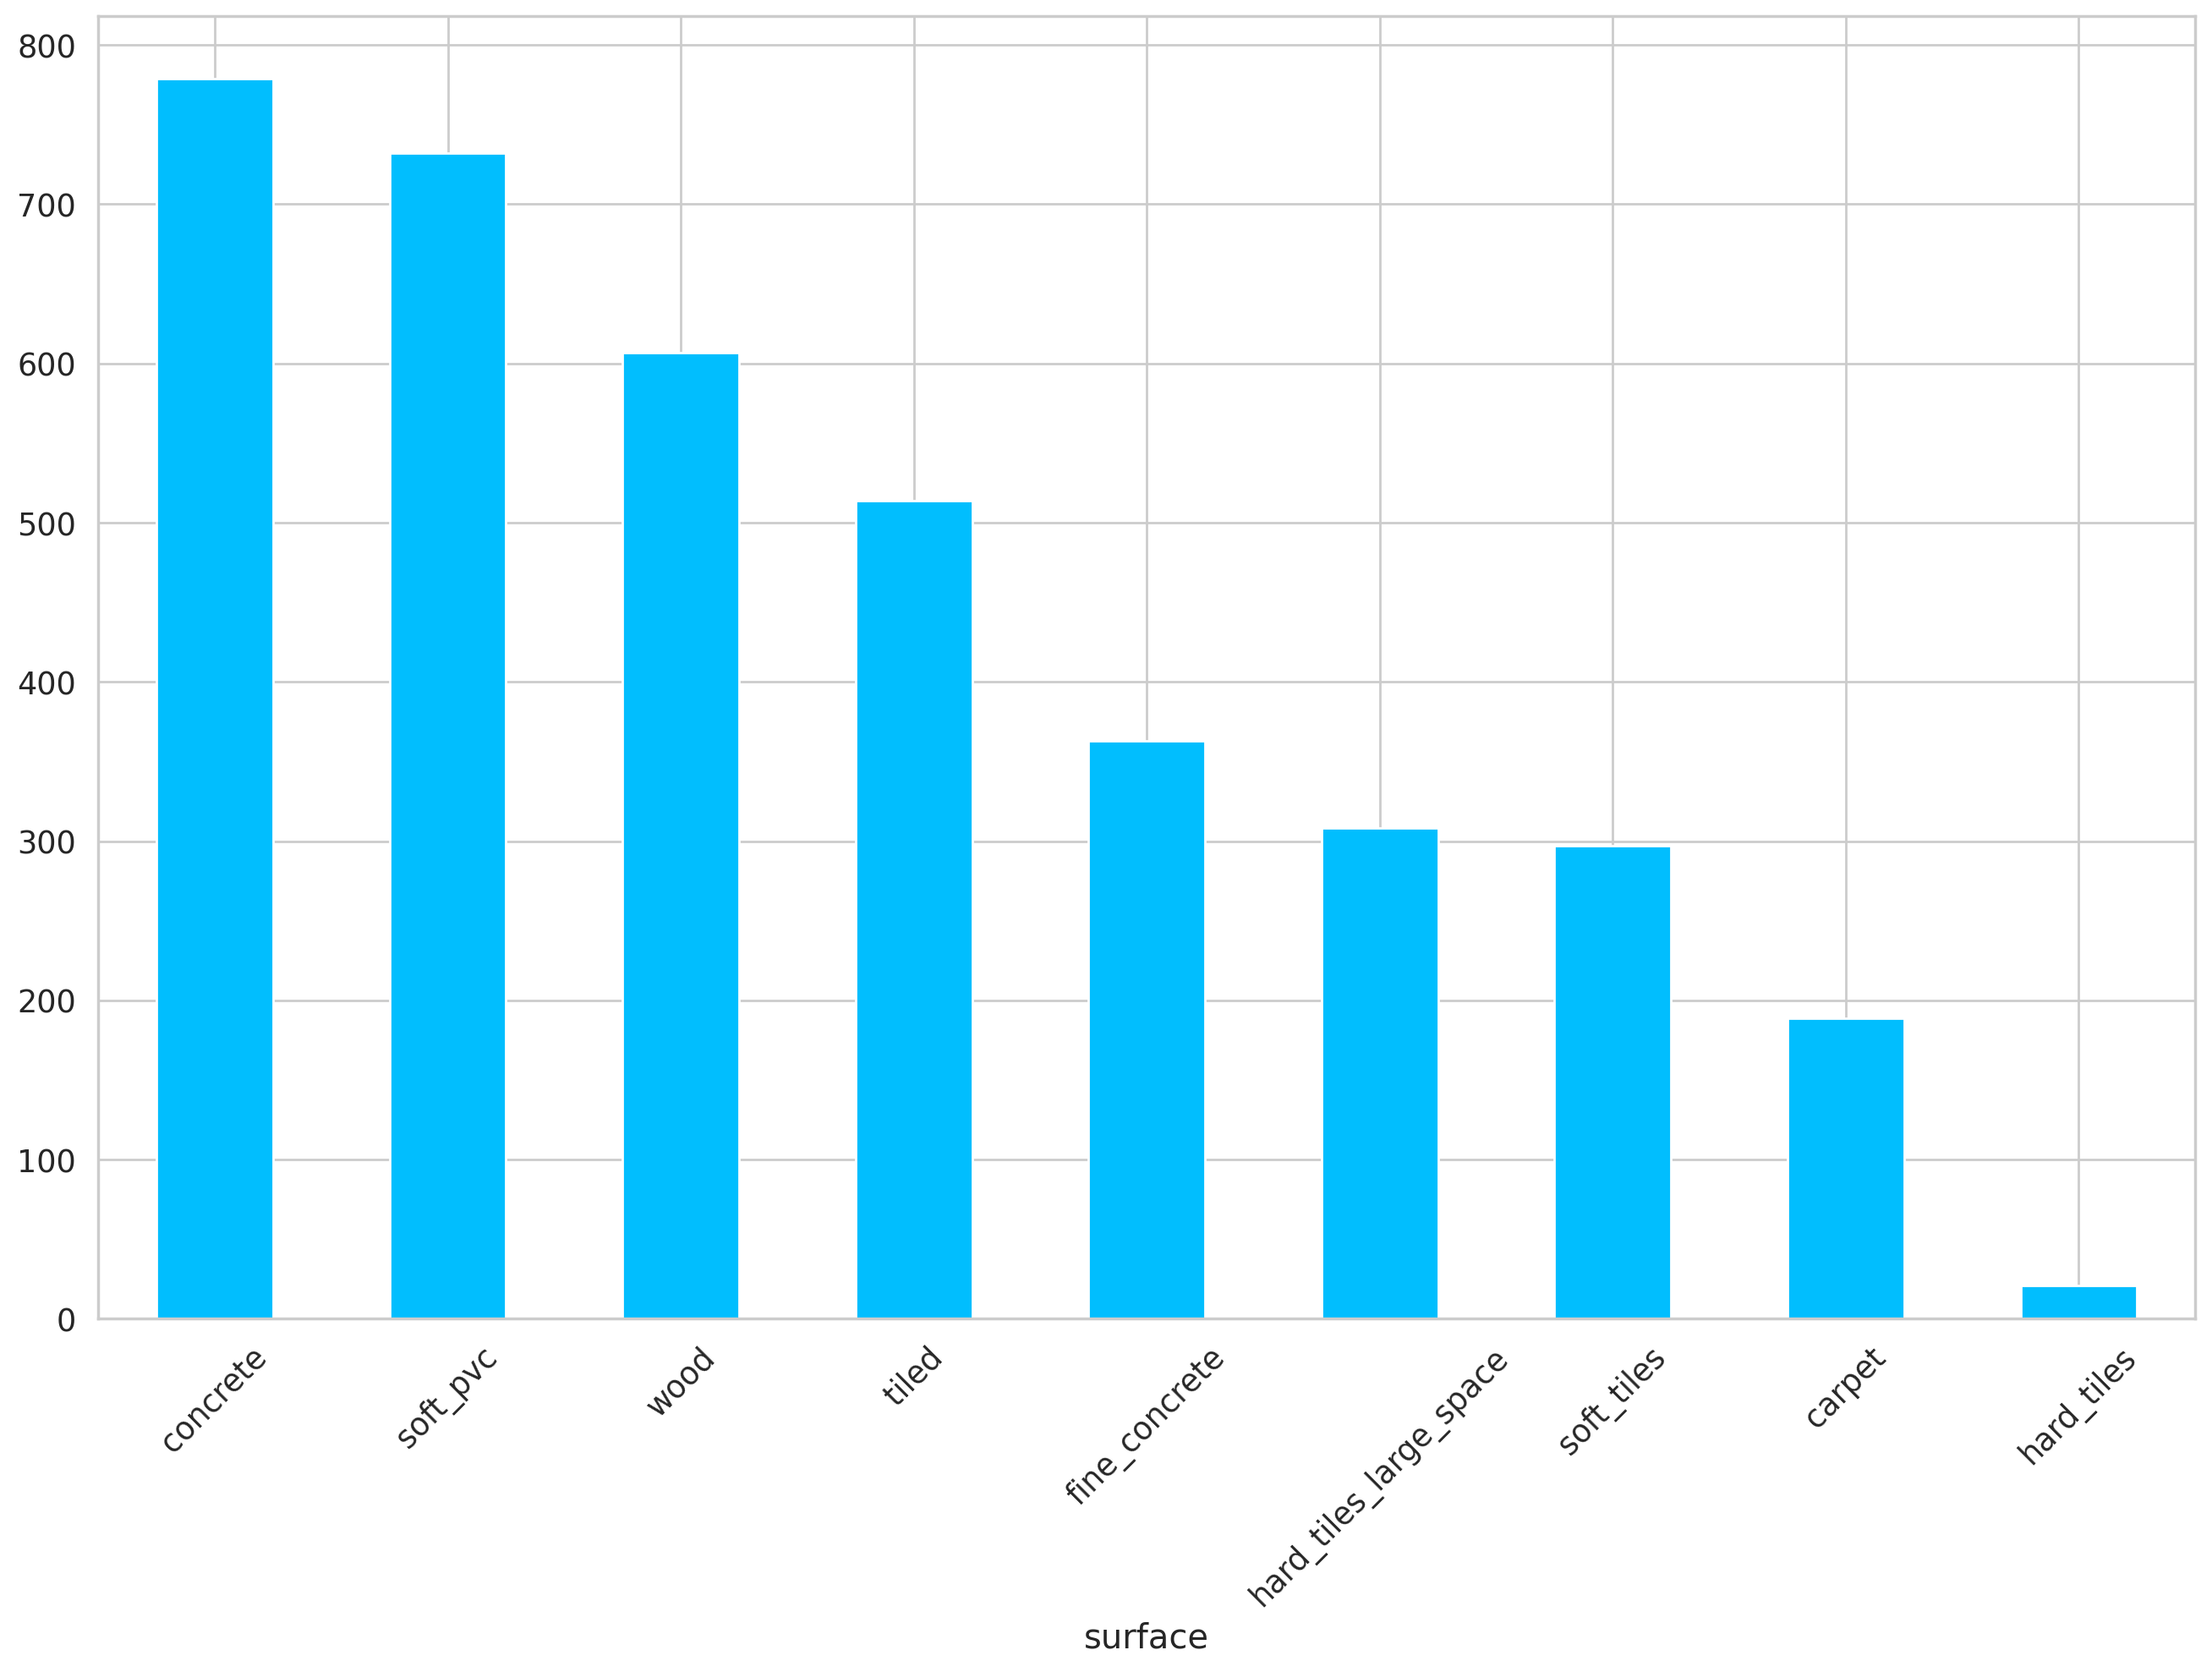

In [7]:
y_train.surface.value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

# Distribution is not balanced, so might use resampling or other technique for balancing this data set

# Preprocessing to convert string values of surfaces to integers for neural network

In [8]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_train.surface)

In [9]:
encoded_labels[:5]

array([2, 1, 1, 1, 6])

In [10]:
#labels are stored in the classes_ property in label encoder
label_encoder.classes_
# to reverse transformation if and when needed

array(['carpet', 'concrete', 'fine_concrete', 'hard_tiles',
       'hard_tiles_large_space', 'soft_pvc', 'soft_tiles', 'tiled',
       'wood'], dtype=object)

In [11]:
y_train["label"]=encoded_labels

In [12]:
y_train.head()

,series_id,group_id,surface,label
0,0,13,fine_concrete,2
1,1,31,concrete,1
2,2,20,concrete,1
3,3,31,concrete,1
4,4,22,soft_tiles,6


In [13]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [14]:
FEATURE_COLUMNS = X_train.columns.tolist()[3:]
FEATURE_COLUMNS

['orientation_X',
 'orientation_Y',
 'orientation_Z',
 'orientation_W',
 'angular_velocity_X',
 'angular_velocity_Y',
 'angular_velocity_Z',
 'linear_acceleration_X',
 'linear_acceleration_Y',
 'linear_acceleration_Z']

In [15]:
X_train.series_id.value_counts()

series_id
3809    128
0       128
3770    128
3771    128
3772    128
       ... 
5       128
6       128
7       128
8       128
9       128
Name: count, Length: 3810, dtype: int64

In [16]:
(X_train.series_id.value_counts()==128).sum() == len(y_train)
# check that all the sequences have 128 of series ids (grouped datapoints for each time step)

True

In [17]:
# group by series_id

sequences = []

for series_id , group in X_train.groupby("series_id"):
    sequence_features = group[FEATURE_COLUMNS]
    label = y_train[y_train.series_id== series_id].iloc[0].label

    sequences.append((sequence_features,label ))
    

In [18]:
sequences[0]

(     orientation_X  orientation_Y  orientation_Z  orientation_W  \
 0         -0.75853       -0.63435       -0.10488       -0.10597   
 1         -0.75853       -0.63434       -0.10490       -0.10600   
 2         -0.75853       -0.63435       -0.10492       -0.10597   
 3         -0.75852       -0.63436       -0.10495       -0.10597   
 4         -0.75852       -0.63435       -0.10495       -0.10596   
 ..             ...            ...            ...            ...   
 123       -0.75943       -0.63316       -0.10470       -0.10677   
 124       -0.75945       -0.63313       -0.10473       -0.10683   
 125       -0.75949       -0.63309       -0.10467       -0.10690   
 126       -0.75950       -0.63307       -0.10464       -0.10693   
 127       -0.75953       -0.63306       -0.10461       -0.10684   
 
      angular_velocity_X  angular_velocity_Y  angular_velocity_Z  \
 0              0.107650            0.017561            0.000767   
 1              0.067851            0.029939  

In [19]:
train_sequences, test_sequences = train_test_split(sequences, test_size=0.2)

len(train_sequences) , len(test_sequences)



(3048, 762)

# Dataset

In [20]:
class SurfaceDataset(Dataset):
    
    def __init__(self, sequences):
        self.sequences = sequences
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self,idx):
        sequence , label = self.sequences[idx]
        return dict(
        sequence=torch.Tensor(sequence.to_numpy()),
            label = torch.tensor(label).long()
        )

In [21]:
class SurfaceDataModule(pl.LightningDataModule):
    
    def __init__(self, train_sequences , test_sequences , batch_size):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size
        
    def setup(self, stage=None):
        self.train_dataset = SurfaceDataset(self.train_sequences)
        self.test_dataset = SurfaceDataset(self.test_sequences)
        

    def train_dataloader(self):
        return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=True,
        num_workers=cpu_count())
    
    def val_dataloader(self):
        return DataLoader(
        self.test_dataset,
        batch_size = self.batch_size,
        shuffle=False,
        num_workers=cpu_count())
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )
    

In [22]:
N_EPOCHS = 250
BATCH_SIZE = 64

data_module = SurfaceDataModule(train_sequences, test_sequences, BATCH_SIZE)

# Model

In [23]:
class SequenceModel(nn.Module):
    # classification, number of hidden units, number of layers for LSTM
    
    def __init__(self, n_features, n_classes , n_hidden=256, n_layers=3):
        super().__init__()
        
        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size=n_hidden,
        num_layers=n_layers,
        batch_first=True,
        dropout=0.75)
        
        self.classifier = nn.Linear(n_hidden , n_classes)
        
    def forward(self, x):
        self.lstm.flatten_parameters()
        _, (hidden, _) = self.lstm(x)
        
        out = hidden[-1]
        
        return self.classifier(out)

In [24]:
# !kill 4839
# %reload_ext tensorboard
# %tensorboard --logdir lightning_logs/

# from pytorch_lightning.callbacks import Callback

# class MetricsLogger(Callback):
#     def on_epoch_end(self, trainer, pl_module):
#         print(f"Epoch {trainer.current_epoch}: train_loss={trainer.callback_metrics['train_loss']}")

In [25]:
# %reload_ext tensorboard
# %tensorboard --logdir logs

In [26]:
class SurfacePredictor(pl.LightningModule):
    
    def __init__(self, n_features:int , n_classes: int):
        super().__init__()
        self.model = SequenceModel(n_features,n_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy_metric = Accuracy(task='multiclass', num_classes=n_classes) # updated syntax for new version of pytorch lightning torchmetrics Accuracy 
        
    def forward(self,  x, labels=None):
        output = self.model(x)
        loss=0
        if labels is not None:
            loss=self.criterion(output, labels)
        return loss, output
    
    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences , labels)
        predictions = torch.argmax(outputs , dim=1)
        step_accuracy=self.accuracy_metric(predictions, labels)
        
        self.log("train_loss", loss , prog_bar=True , logger=True )
        self.log("train_accuracy" , step_accuracy, prog_bar=True , logger=True)
        return {"loss":loss , "accuracy":step_accuracy}
    # log everything to tensorboard
    
    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences , labels)
        predictions = torch.argmax(outputs , dim=1)
        step_accuracy=self.accuracy_metric(predictions, labels)
        
        self.log("val_loss", loss , prog_bar=True , logger=True )
        self.log("val_accuracy" , step_accuracy, prog_bar=True , logger=True)
        return {"loss":loss , "accuracy":step_accuracy}
        
    def test_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences , labels)
        predictions = torch.argmax(outputs , dim=1)
        step_accuracy=self.accuracy_metric(predictions, labels)
        
        self.log("test_loss", loss , prog_bar=True , logger=True )
        self.log("test_accuracy" , step_accuracy, prog_bar=True, logger=True)
        return {"loss":loss , "accuracy":step_accuracy}        
        
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.0001)

#     def on_train_epoch_end(self, outputs):
#         # Calculate and log epoch metrics to .txt file
#         avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
#         avg_train_accuracy = torch.stack([x["accuracy"] for x in outputs]).mean()
#         self.log_to_file("train", avg_train_loss, avg_train_accuracy, self.current_epoch)
    
#     def on_validation_epoch_end(self, outputs):
#         # Calculate and log epoch metrics to .txt file
#         avg_val_loss = torch.stack([x["loss"] for x in outputs]).mean()
#         avg_val_accuracy = torch.stack([x["accuracy"] for x in outputs]).mean()
#         self.log_to_file("val", avg_val_loss, avg_val_accuracy, self.current_epoch)
    
#     def log_to_file(self, stage, loss, accuracy, epoch):
#         with open("training_logs.txt", "a") as f:
#             f.write(f"Epoch {epoch + 1}, {stage}_loss: {loss:.4f}, {stage}_accuracy: {accuracy:.4f}\n")

In [27]:
model = SurfacePredictor(
    n_features = len(FEATURE_COLUMNS),
    n_classes = len(label_encoder.classes_)
)

In [28]:
%reload_ext tensorboard
%tensorboard --logdir ./lightning_logs

In [29]:
checkpoint_callback = ModelCheckpoint(
dirpath="checkpoints",
filename="best-checkpoint",
save_top_k=1,
verbose=True,
monitor="val_loss",
mode="min")

logger = TensorBoardLogger("lightning_logs", name="surface")

trainer=pl.Trainer(
logger=logger,
callbacks=[checkpoint_callback],
max_epochs=N_EPOCHS,
accelerator="gpu",  # Specify the accelerator type
devices=1,  # Number of GPUs to use
enable_progress_bar=True  # Optionally set to False if you want to disable it
)

In [30]:
trainer.fit(model, data_module)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (48) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]